# Import libraries

In [2]:
import sys
sys.path.append("../")

In [3]:
from libraries.dataManipulation import *
from libraries.gridManipulation import *
import time
import datetime
import pandas as pd
import pytz

# Create the grid

In [4]:
#GRID CONFIGURATION IS DECLARED
o_x = 5000
o_y = -9000
o = (o_x,o_y)

#TOTAL GRID SHOULD BE SIZE 67000x13000
patch_width = 1000
patch_height = 1000
patch_size = (patch_width, patch_height)

total_patches = (67,13)
abs_total_patches = total_patches[0]*total_patches[1]

grid_angle = 0.81

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


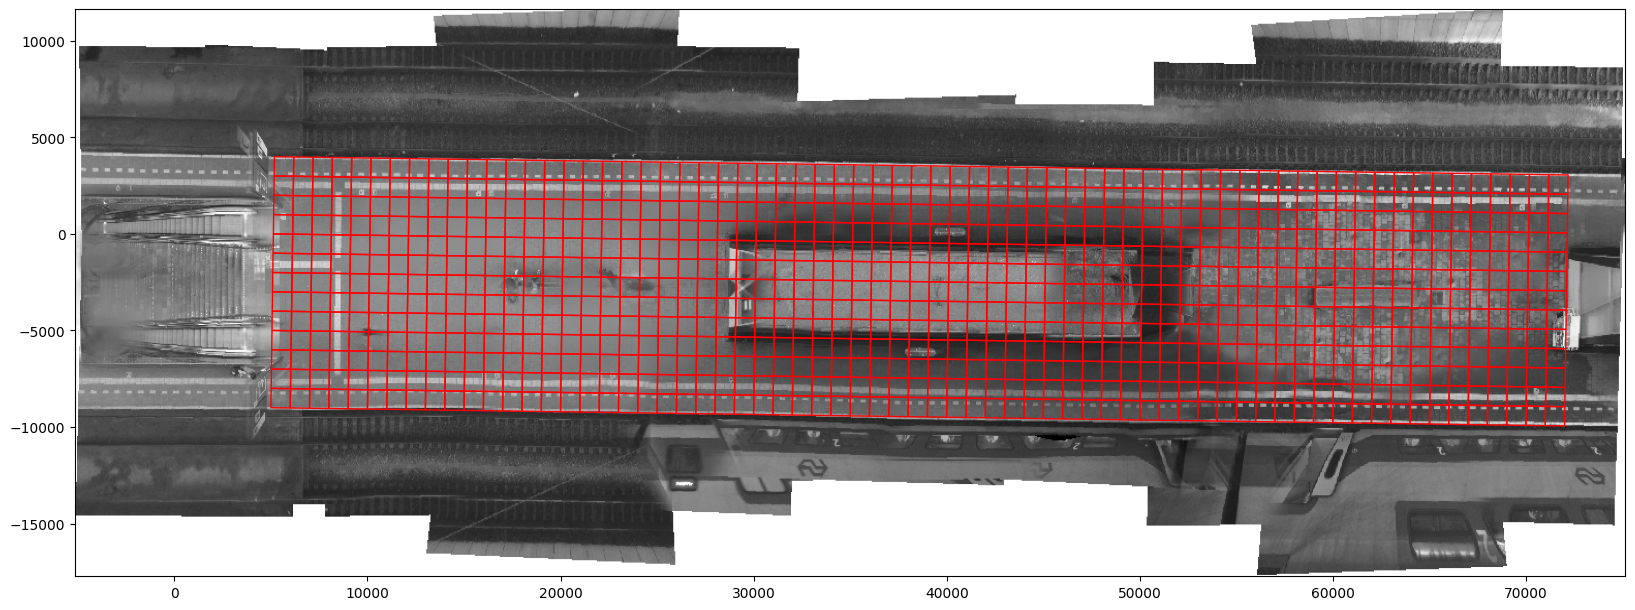

In [5]:
#GRID IS CREATED USING CONFIG
grid = create_grid(o, patch_size, total_patches, grid_angle)
#GRID IS PLOTTED ON STATION
plot_grid(grid, 'ehv')

# Get data

In [6]:
days = [20220311]

In [7]:
# Storage connection class
dh = SociophysicsDataHandler()

daylist = dh.list_files('/ehv/platform2.1')['name']
day_numbers = []
for i in range(len(daylist)):
    day_numbers.append(int(daylist[i]))

targeting path /storage/surfsara/ProRail_USE_LL_data//ehv/platform2.1
Files listed. Accessible as <this-object>.filelist


In [8]:
%%time
data = pd.DataFrame({'date_time_utc' : [],
                    'tracked_object' : [],
                    'y_pos' : [], 'x_pos' : [],
                    'datetime' : []})
for day in days:
    day_data = getDay(day, 'ehv')
    day_data = day_data.drop(day_data[day_data.x_pos < o_x].index)
    day_data = day_data.drop(day_data[day_data.y_pos < o_y].index)
    day_data = day_data.drop(day_data[day_data.x_pos > (total_patches[0]-1)*patch_width].index)
    day_data = day_data.drop(day_data[day_data.y_pos > (total_patches[1]-1)*patch_height].index)
    day_data = day_data.drop(['datetime'], axis=1)
    day_data['time'] = (day_data['date_time_utc'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    data = pd.concat([data, day_data])


targeting path /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220311
Files listed. Accessible as <this-object>.filelist
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220311/EHV_Platform2.1_2022031100_trajectorie.parquet
data fetched. Accessible as <this-object>.df
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220311/EHV_Platform2.1_2022031100_trajectorie.parquet
data fetched. Accessible as <this-object>.df
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220311/EHV_Platform2.1_2022031101_trajectorie.parquet
data fetched. Accessible as <this-object>.df
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220311/EHV_Platform2.1_2022031102_trajectorie.parquet
data fetched. Accessible as <this-object>.df
trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/platform2.1/20220311/EHV_Platform2.1_2022031103_trajectorie.parquet
data fetched. Accessible as <this-object>.df
trying to f

In [9]:
data

,date_time_utc,tracked_object,y_pos,x_pos,datetime,time
0,2022-03-10 23:00:00.000,3245497.0,-3067.0,61157.0,NaN,1.646953e+09
1,2022-03-10 23:00:00.000,3245500.0,-3096.0,60511.0,NaN,1.646953e+09
2,2022-03-10 23:00:00.000,3245508.0,-5603.0,35272.0,NaN,1.646953e+09
3,2022-03-10 23:00:00.000,3245511.0,-3189.0,63409.0,NaN,1.646953e+09
4,2022-03-10 23:00:00.000,3245515.0,-2199.0,62269.0,NaN,1.646953e+09
...,...,...,...,...,...,...
24565584,2022-03-11 22:59:59.900,3292897.0,-2581.0,61485.0,NaN,1.647040e+09
24565585,2022-03-11 22:59:59.900,3292905.0,-3160.0,61752.0,NaN,1.647040e+09
24565586,2022-03-11 22:59:59.900,3292907.0,-730.0,54459.0,NaN,1.647040e+09
24565587,2022-03-11 22:59:59.900,3292908.0,-3029.0,59094.0,NaN,1.647040e+09


# Assign direction to objects in data

In [10]:
%%time

# Use function in library to calculate direction of each person in the platform and create a dataframe with the results
directions = direction_label(data)
directions

CPU times: user 10.3 s, sys: 1.43 s, total: 11.7 s
Wall time: 11.8 s


,tracked_object,direction
0,3245497.0,offboarding
1,3245500.0,offboarding
2,3245508.0,offboarding
3,3245511.0,offboarding
4,3245515.0,offboarding
...,...,...
41138,3292905.0,offboarding
41139,3292906.0,onboarding
41140,3292907.0,onboarding
41141,3292908.0,onboarding


In [11]:
#See quality of the direction labeling

## Offboarding and onboarding should be as close as 50% as possible
## Undefined should be as close to 0% as possible

stats = directions['direction'].value_counts(normalize=True)*100
stats['undefined']

0.47881778188270174

In [12]:
#Add directions to complete dataframe
data['direction'] = 'unassigned'
directions_dict = directions.set_index('tracked_object')['direction'].to_dict()
data['direction'] = data['tracked_object'].map(directions_dict)

# Separation by direction

In [13]:
data_off = data[data['direction']=='offboarding']
data_on = data[data['direction']=='onboarding']
data_off = data_off.drop('direction',axis=1)
data_on = data_on.drop('direction',axis=1)

In [14]:
data_off

,date_time_utc,tracked_object,y_pos,x_pos,datetime,time
0,2022-03-10 23:00:00.000,3245497.0,-3067.0,61157.0,NaN,1.646953e+09
1,2022-03-10 23:00:00.000,3245500.0,-3096.0,60511.0,NaN,1.646953e+09
2,2022-03-10 23:00:00.000,3245508.0,-5603.0,35272.0,NaN,1.646953e+09
3,2022-03-10 23:00:00.000,3245511.0,-3189.0,63409.0,NaN,1.646953e+09
4,2022-03-10 23:00:00.000,3245515.0,-2199.0,62269.0,NaN,1.646953e+09
...,...,...,...,...,...,...
24565579,2022-03-11 22:59:59.800,3292909.0,-2608.0,62042.0,NaN,1.647040e+09
24565582,2022-03-11 22:59:59.900,3292868.0,-3171.0,63559.0,NaN,1.647040e+09
24565584,2022-03-11 22:59:59.900,3292897.0,-2581.0,61485.0,NaN,1.647040e+09
24565585,2022-03-11 22:59:59.900,3292905.0,-3160.0,61752.0,NaN,1.647040e+09


In [15]:
data_on

,date_time_utc,tracked_object,y_pos,x_pos,datetime,time
4183,2022-03-10 23:00:51.500,3245528.0,-5470.0,5040.0,NaN,1.646953e+09
4192,2022-03-10 23:00:51.600,3245528.0,-5470.0,5122.0,NaN,1.646953e+09
4201,2022-03-10 23:00:51.700,3245528.0,-5470.0,5177.0,NaN,1.646953e+09
4210,2022-03-10 23:00:51.800,3245528.0,-5471.0,5314.0,NaN,1.646953e+09
4219,2022-03-10 23:00:51.900,3245528.0,-5499.0,5397.0,NaN,1.646953e+09
...,...,...,...,...,...,...
24565580,2022-03-11 22:59:59.900,3292864.0,-3034.0,60164.0,NaN,1.647040e+09
24565581,2022-03-11 22:59:59.900,3292865.0,-2033.0,59317.0,NaN,1.647040e+09
24565583,2022-03-11 22:59:59.900,3292876.0,-763.0,53538.0,NaN,1.647040e+09
24565586,2022-03-11 22:59:59.900,3292907.0,-730.0,54459.0,NaN,1.647040e+09


In [16]:
(data_on.iloc[0]['time'], data_on.iloc[-1]['time'])

(1646953251.0, 1647039599.0)

Note: Onboarding dataframe should be much bigger than offboarding dataframe, as people spend more time in the platform (waiting) when they are on boarding.

# Separation by train presence

In [17]:
train_data = SociophysicsDataHandler()
train_data.fetch_prorail_train_information(station='ehv')
train_data = train_data.train_information

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/ehv_train_information_pss.parquet
data fetched. Accessible as <this-object>.train_information


In [18]:
#Drop non useful columns
train_data = train_data.drop(columns=['date', 'station', 'door_no', 'door_x', 'door_y'])

In [19]:
def to_unix_timestamp(dt):
    return dt.timestamp()

train_data['arrival_unix'] = train_data['arrival_time'].apply(to_unix_timestamp)
train_data['departure_unix'] = train_data['departure_time'].apply(to_unix_timestamp)

In [20]:
train_data

,train_number,arrival_time,departure_time,arrival_unix,departure_unix
0,832,2021-01-01 10:02:02+01:00,2021-01-01 10:06:04+01:00,1.609492e+09,1.609492e+09
1,834,2021-01-01 10:31:37+01:00,2021-01-01 10:36:03+01:00,1.609493e+09,1.609494e+09
2,836,2021-01-01 11:04:20+01:00,2021-01-01 11:07:49+01:00,1.609495e+09,1.609496e+09
3,838,2021-01-01 11:32:09+01:00,2021-01-01 11:36:02+01:00,1.609497e+09,1.609497e+09
4,840,2021-01-01 12:02:02+01:00,2021-01-01 12:05:50+01:00,1.609499e+09,1.609499e+09
...,...,...,...,...,...
152850,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09
152851,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09
152852,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09
152853,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09


In [21]:
data_on

,date_time_utc,tracked_object,y_pos,x_pos,datetime,time
4183,2022-03-10 23:00:51.500,3245528.0,-5470.0,5040.0,NaN,1.646953e+09
4192,2022-03-10 23:00:51.600,3245528.0,-5470.0,5122.0,NaN,1.646953e+09
4201,2022-03-10 23:00:51.700,3245528.0,-5470.0,5177.0,NaN,1.646953e+09
4210,2022-03-10 23:00:51.800,3245528.0,-5471.0,5314.0,NaN,1.646953e+09
4219,2022-03-10 23:00:51.900,3245528.0,-5499.0,5397.0,NaN,1.646953e+09
...,...,...,...,...,...,...
24565580,2022-03-11 22:59:59.900,3292864.0,-3034.0,60164.0,NaN,1.647040e+09
24565581,2022-03-11 22:59:59.900,3292865.0,-2033.0,59317.0,NaN,1.647040e+09
24565583,2022-03-11 22:59:59.900,3292876.0,-763.0,53538.0,NaN,1.647040e+09
24565586,2022-03-11 22:59:59.900,3292907.0,-730.0,54459.0,NaN,1.647040e+09


In [22]:
unix_timestamp_day_start = data_on.iloc[0]['time']
train_data.iloc[-1]
#unix_timestamp_day_start 1667344086.0

train_number                         803516
arrival_time      2022-10-28 05:37:23+02:00
departure_time    2022-10-28 05:47:12+02:00
arrival_unix                   1666928243.0
departure_unix                 1666928832.0
Name: 152854, dtype: object

In [23]:
unix_timestamp_day_start = data_on.iloc[0]['time']
unix_timestamp_day_end = data_on.iloc[-1]['time']
day_train_data = train_data[train_data['arrival_unix']>1600000000]

In [24]:
day_train_data

,train_number,arrival_time,departure_time,arrival_unix,departure_unix
0,832,2021-01-01 10:02:02+01:00,2021-01-01 10:06:04+01:00,1.609492e+09,1.609492e+09
1,834,2021-01-01 10:31:37+01:00,2021-01-01 10:36:03+01:00,1.609493e+09,1.609494e+09
2,836,2021-01-01 11:04:20+01:00,2021-01-01 11:07:49+01:00,1.609495e+09,1.609496e+09
3,838,2021-01-01 11:32:09+01:00,2021-01-01 11:36:02+01:00,1.609497e+09,1.609497e+09
4,840,2021-01-01 12:02:02+01:00,2021-01-01 12:05:50+01:00,1.609499e+09,1.609499e+09
...,...,...,...,...,...
152850,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09
152851,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09
152852,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09
152853,803516,2022-10-28 05:37:23+02:00,2022-10-28 05:47:12+02:00,1.666928e+09,1.666929e+09


In [25]:
%%time
trains_in_day = len(day_train_data.index)
data_on['train'] = False
for train in range(trains_in_day):
    arrival = day_train_data.loc[train]['arrival_unix']
    departure = day_train_data.loc[train]['departure_unix']
    data_on.loc[(data_on['time'] > arrival) & (data_on['time'] < departure), 'train'] = True
    


KeyboardInterrupt



In [ ]:
data_on_train = data_on[data_on['train']==True]
data_on_no_train = data_on[data_on['train']==False]
data_on_train = data_on_train.drop('train',axis=1)
data_on_no_train = data_on_no_train.drop('train',axis=1)

In [ ]:
data_on_train